# Neural Posterior Estimation

In this notebook we train a Mixture Density Network (MDN) for Neural Posterior Estimation (NPE).

In this example we will:
1. Generate some simulated data.
2. Train a MDN.
3. Assess prediction accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import tensorflow.math as tfm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

## 1. Generating some data

Like many all of the other notebooks in this repo we start by simulating our data. For the full version of this see `MCMC_zeus.ipynb`.

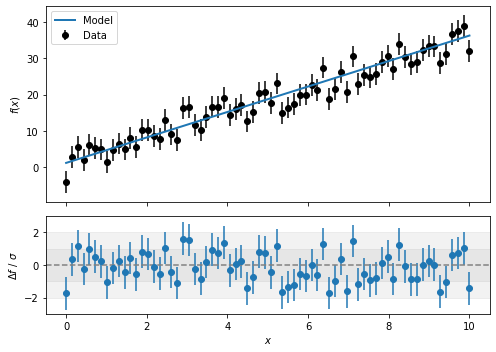

In [2]:
np.random.seed(100) # We set the random seed for numpy so we get the
                    # same synthetic data each time the notebook is run.

def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

m_true = 3.5 
c_true = 1.2 

num_points = 70
x = np.linspace(0, 10, num_points)

sigma = 3.0

data = np.random.normal(loc=straight_line(x, m_true, c_true), scale=sigma)

fig, ax = plt.subplots(2,1,sharex=True, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

ax[0].errorbar(x, data, yerr=sigma, fmt="o", color='k', zorder=1, label='Data')
ax[0].plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='Model')
ax[0].legend()
ax[0].set_ylabel(r'$f(x)$')

ax[1].errorbar(x, (data-straight_line(x, m_true, c_true))/sigma, yerr=1., fmt="o")
ax[1].axhline(0., linestyle='--', color='grey')
ax[1].axhspan(-1,1, alpha=0.1, color='grey')
ax[1].axhspan(-2,2, alpha=0.1, color='grey')
ax[1].set_ylim(-3,3)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$\Delta f \ / \ \sigma$')

plt.tight_layout()
plt.show()

## 2. Train a MDN.

We start by defining the functions required to generate the necessary training data.

First we define a function that allows us to randomly sample from the prior. As with all other notebooks in this repo our prior takes the form of a uniform prior on the intercept $c \sim \mathcal{U}(-10,10)$ and a normal prior on the gradient $m \sim \mathcal{N}(3, 10)$.

In [3]:
def prior(N):
    
    rand_c = np.random.uniform(-10., 10., size=(N, ))
    rand_m = np.random.normal(loc=3., scale=10., size=(N, ))
    
    return np.vstack([rand_m, rand_c]).T

Next we define a 'simulator' function. This function generates simulated observations by making model predictions and introduces noise at the same level that we have in our data.

In [4]:
def simulator(theta, sigma, x):
    
    models = theta[:,0]*x.reshape(-1,1) + theta[:,1]

    return np.random.normal(loc=models, scale=sigma).T

We can now use these functions to generate some training data. We generate 50,000 examples, this is similar to the total number of likelihood evaluations when running our MCMC, see `MCMC_zeus.ipynb`. We use 40,000 for training and 10,000 for validation.

In [5]:
trainX = prior(40000)
trainY = simulator(trainX, sigma, x)

valX = prior(10000)
valY = simulator(valX, sigma, x)

trainX.shape, trainY.shape

((40000, 2), (40000, 70))

Before we train our MDN we standardize our training and validations data.

In [6]:
yscaler = StandardScaler()
xscaler = StandardScaler()

trainy = yscaler.fit_transform(trainY)
valy = yscaler.transform(valY)

trainx = xscaler.fit_transform(trainX)
valx = xscaler.transform(valX)

Now we define our MDN. A MDN predicts parameters of a series of component distributions, e.g. a series of Gaussians. The distribution predicted by the network can be written as

$$P(x|y, w) = \sum_i^{n_c} r_i(y, w)\mathcal{N}\left[\mu_i(y,w), C_i(y,w)\right],$$

where $w$ are the weights of the MDN, and $n_c$ is the number of component Gaussians.

For this simple example we only need to use a single component. It is very simple to define this network using [tensorflow-probability](https://www.tensorflow.org/probability/overview).

In [7]:
input_layer1 = Input(shape=(int(trainy.shape[1]),))

d1 = Dense(25, activation = 'tanh')(input_layer1)
d2 = Dense(25, activation = 'tanh')(d1)
d3 = Dense(25, activation = 'tanh')(d2)
d4 = Dense(25, activation = 'tanh')(d3)
d5 = Dense(25, activation = 'tanh')(d4)
output = Dense(5, activation = 'linear')(d5)

dist1 = tfp.layers.MultivariateNormalTriL(2, name="dist1")(output)

MDN = Model(inputs=input_layer1, outputs=dist1)

Our loss function is the negative log-probability $-\ln{P(x|y, w)}$.

In [8]:
neglogprob = lambda y, p_y: -p_y.log_prob(y)

We can now train our MDN. We define a callback that will terminate training when the loss function plateaus.

In [9]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                           verbose=0, mode='min', baseline=None,
                           restore_best_weights=True)
callbacks_list = [early_stop]

MDN.compile(optimizer=Adam(lr=0.00001), loss=neglogprob)
MDN.fit(trainy,trainx, validation_data=[valy, valx] , epochs=200, batch_size=16, verbose=1,
        callbacks=callbacks_list)

/Users/jamie/opt/anaconda3/envs/tf_prob/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
2500/2500 [==============================] - 3s 1ms/step - loss: 2.2790 - val_loss: 1.4095
Epoch 2/200
2500/2500 [==============================] - 2s 971us/step - loss: 1.1519 - val_loss: 0.9520
Epoch 3/200
2500/2500 [==============================] - 2s 969us/step - loss: 0.6495 - val_loss: 0.2912
Epoch 4/200
2500/2500 [==============================] - 2s 973us/step - loss: -0.1017 - val_loss: -0.4091
Epoch 5/200
2500/2500 [==============================] - 2s 969us/step - loss: -0.6087 - val_loss: -0.7415
Epoch 6/200
2500/2500 [==============================] - 2s 978us/step - loss: -0.8565 - val_loss: -0.9379
Epoch 7/200
2500/2500 [==============================] - 2s 968us/step - loss: -1.0259 - val_loss: -1.0925
Epoch 8/200
2500/2500 [==============================] - 3s 1ms/step - loss: -1.1667 - val_loss: -1.2259
Epoch 9/200
2500/2500 [==============================] - 3s 1ms/step - loss: -1.2914 - val_loss: -1.3424
Epoch 10/200
2500/2500 [=========================

2500/2500 [==============================] - 3s 1ms/step - loss: -3.2427 - val_loss: -3.2511
Epoch 79/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2521 - val_loss: -3.2476
Epoch 80/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2588 - val_loss: -3.2683
Epoch 81/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2684 - val_loss: -3.2588
Epoch 82/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2775 - val_loss: -3.2799
Epoch 83/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2842 - val_loss: -3.2847
Epoch 84/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2958 - val_loss: -3.2886
Epoch 85/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3013 - val_loss: -3.3016
Epoch 86/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3093 - val_loss: -3.3195
Epoch 87/200
2500/2500 [==============================] - 3

Epoch 155/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6609 - val_loss: -3.6360
Epoch 156/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6640 - val_loss: -3.6674
Epoch 157/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6683 - val_loss: -3.6642
Epoch 158/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6695 - val_loss: -3.6680
Epoch 159/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6735 - val_loss: -3.6609
Epoch 160/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6756 - val_loss: -3.6841
Epoch 161/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6781 - val_loss: -3.6328
Epoch 162/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6813 - val_loss: -3.6787
Epoch 163/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.6845 - val_loss: -3.6881
Epoch 164/200
2500/2500 [============

## 3. Prediction accuracy.

Before making posterior predictions for our data we can use the validation set to assess our MDN. In this example we follow [Wagner-Carena et al. (2020)](https://arxiv.org/abs/2010.13787) and [Park et al. (2020)](https://arxiv.org/abs/2012.00042) and focus on two key points:
1. How well calibrated are the uncertainty predictions?
2. What is the absolute error on the posterior mean predictions?

In section 4.1.1 of Wagner-Carena et al. (2020) and section 2.3.3 of Park et al. (2020) they describe the _frequency calibration_ can be used to answer point 1. The metric is defined with the equations below:

$$p_Y(p_X) = \frac{1}{N}\sum_i^{N}p_Y^{i}(p_X)\ ,$$

$$p_Y^{i}(p_X) = \mathbb{1}\left\{\frac{1}{n}\sum_j^n\mathbb{1}\left\{d(\theta)<d(\theta_o)\right\}<p_X\right\}\ ,$$

$$d(\theta) = \sqrt{(\theta-\mu)C^{-1}(\theta-\mu)^T}\ ,$$

$$
\mathbb{1}\left\{\dots\right\} =
    \begin{cases}
    0 ,\ \mathrm{when\ False}\\
    1,\ \mathrm{when\ True}
    \end{cases}
\ .
$$

We suggest reading the relevant sections of Wagner-Carena et al. (2020) and Park et al. (2020) for more details about this metric. Very briefly this metric qunatifies how ofter the true parameters $\theta_o$ are found within a given posterior volume $p_X$. Evaluating this metric requires predicting the posterior for $N$ parameters sets, and sampling these predicted posteriors $n$ times.

Defining the above equations as Python functions is quite simple. We start with our distance measure $d(\theta)$.

In [10]:
def distance(samples, post_mean, post_cov):
    '''
    Args:
        samples (array): Array containing the samples to be evaluated. Must have shape (n, d),
         where n is the number of samples and d is the number of dimensions.
        post_mean (array): Array containing the posterior mean. Must have shape (d, ).
        post_cov (array): Array containing the posterior covariance. Must have shape (d, d).
        
    Returns:
        Array containing the sample distances with shape (n, ).
    '''
    res = samples - post_mean
    return np.einsum("nj,ij,in->n", res, np.linalg.inv(post_cov), res.T)

Next we deffine our function for $p_Y^{i}(p_X)$.

In [11]:
def metric(sample_distance, true_distance):
    '''
    Args:
        sample_distance (array): Array containing the distance measures for
         the n random draws from the posterior.
        true_distance (float): The distance measure for the true parameters.
        
    Returns:
        Array containing pYi. Has shape (100, ).
    '''
    perc = np.sum(sample_distance<true_distance)/sample_distance.shape[0]
    px = np.linspace(0,1,100)
    return np.where(perc<px, 1, 0)

Now we loop over the $N$ samples in the validation set and evaluate $p_Y^{i}(p_X)$. We also log the means and standard deviations from each of the posterior predictions, we use these qunatities later.

It should be noted that this is not the most efficent way to use the MDN, we can easily make predictions without a loop, however storing 5000 samples from 10000 validation samples uses a lot of memory. So we opt for a loop here so the example can be run without consuming large amounts of memory.

In [12]:
pYi = np.zeros((valY.shape[0], 100))
means = np.zeros((valY.shape[0], 2))
stdvs = np.zeros((valY.shape[0], 2))
for i in tqdm(range(valY.shape[0])):
    posterior = MDN(yscaler.transform(valY[i].reshape(1,-1)))
    samples = xscaler.inverse_transform(np.array(posterior.sample(5000)[:,0,:]))
    distance_true = distance(valX[i].reshape(1,-1), samples.mean(axis=0), np.cov(samples, rowvar=False))
    distance_samps = distance(samples, samples.mean(axis=0), np.cov(samples, rowvar=False))
    pYi[i,:] = metric(distance_samps, distance_true)
    means[i,:] = samples.mean(axis=0)
    stdvs[i,:] = samples.std(axis=0)

100%|██████████| 10000/10000 [04:11<00:00, 39.75it/s]


Now we plot $p_Y$ against $p_X$. If our predicted uncertainties are perfectly calibrated we should see a straight line $p_Y = p_X$. If $p_Y>p_X$ it suggests our uncertainties are too large (we are underconfident), and if $p_Y<p_X$ it suggests our uncertainties are too small (we are overconfident).

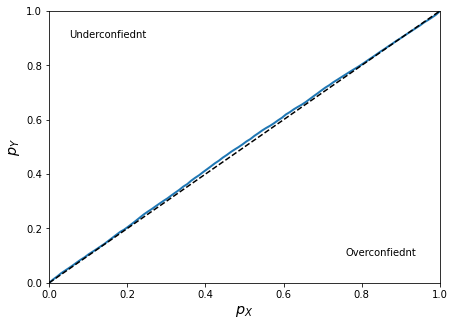

In [13]:
plt.figure(1, figsize=(7,5))
plt.plot(np.linspace(0,1,100),pYi.sum(axis=0)/10000, lw=2)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel(r"$p_X$", fontsize='x-large')
plt.ylabel(r"$p_Y$", fontsize='x-large')
plt.text(0.15, 0.9, "Underconfiednt", horizontalalignment='center')
plt.text(0.85, 0.1, "Overconfiednt", horizontalalignment='center')
plt.show()

From the plot above we can see that our uncertainties are pretty well calibrated. If anything we are slightly underconfident, which is preferential to being overconfident.

To show what poorly calibrated uncertainties would look like on this plot we train a MDN that should perform worse. We limit the output posterior distribution to have the from of an uncorrelated Gaussian which should not well represent the true posterior. We also increase the number of nodes in each layer, deccrease the amount of training data, and now use the training loss for early stopping. This is all a recipe for overfitting!

In [14]:
input_layer1 = Input(shape=(int(trainy.shape[1]),))

d1 = Dense(50, activation = 'tanh')(input_layer1)
d2 = Dense(50, activation = 'tanh')(d1)
d3 = Dense(50, activation = 'tanh')(d2)
d4 = Dense(50, activation = 'tanh')(d3)
d5 = Dense(50, activation = 'tanh')(d4)
output = Dense(4, activation = 'linear')(d5)

dist1 = tfp.layers.IndependentNormal(2, name="dist1")(output)

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=5,
                           verbose=0, mode='min', baseline=None,
                           restore_best_weights=True)
callbacks_list = [early_stop]

MDN2 = Model(inputs=input_layer1, outputs=dist1)
MDN2.compile(optimizer=Adam(lr=0.00001), loss=neglogprob)
MDN2.fit(trainy[:5000],trainx[:5000], epochs=500, batch_size=16,
         verbose=1, callbacks=callbacks_list)

/Users/jamie/opt/anaconda3/envs/tf_prob/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
313/313 [==============================] - 1s 931us/step - loss: 2.2721
Epoch 2/500
313/313 [==============================] - 0s 895us/step - loss: 1.6783
Epoch 3/500
313/313 [==============================] - 0s 901us/step - loss: 1.3179
Epoch 4/500
313/313 [==============================] - 0s 927us/step - loss: 1.0677
Epoch 5/500
313/313 [==============================] - 0s 902us/step - loss: 0.8939
Epoch 6/500
313/313 [==============================] - 0s 911us/step - loss: 0.7131
Epoch 7/500
313/313 [==============================] - 0s 928us/step - loss: 0.4902
Epoch 8/500
313/313 [==============================] - 0s 972us/step - loss: 0.2176
Epoch 9/500
313/313 [==============================] - 0s 930us/step - loss: -0.0852
Epoch 10/500
313/313 [==============================] - 0s 905us/step - loss: -0.3685
Epoch 11/500
313/313 [==============================] - 0s 961us/step - loss: -0.5974
Epoch 12/500
313/313 [==============================] - 0s 975us/step -

313/313 [==============================] - 0s 878us/step - loss: -2.4402
Epoch 97/500
313/313 [==============================] - 0s 894us/step - loss: -2.4450
Epoch 98/500
313/313 [==============================] - 0s 875us/step - loss: -2.4535
Epoch 99/500
313/313 [==============================] - 0s 875us/step - loss: -2.4591
Epoch 100/500
313/313 [==============================] - 0s 873us/step - loss: -2.4664
Epoch 101/500
313/313 [==============================] - 0s 877us/step - loss: -2.4735
Epoch 102/500
313/313 [==============================] - 0s 877us/step - loss: -2.4794
Epoch 103/500
313/313 [==============================] - 0s 891us/step - loss: -2.4855
Epoch 104/500
313/313 [==============================] - 0s 872us/step - loss: -2.4922
Epoch 105/500
313/313 [==============================] - 0s 887us/step - loss: -2.4976
Epoch 106/500
313/313 [==============================] - 0s 1ms/step - loss: -2.5057
Epoch 107/500
313/313 [==============================] - 0s 88

313/313 [==============================] - 0s 879us/step - loss: -2.8514
Epoch 191/500
313/313 [==============================] - 0s 879us/step - loss: -2.8559
Epoch 192/500
313/313 [==============================] - 0s 878us/step - loss: -2.8600
Epoch 193/500
313/313 [==============================] - 0s 880us/step - loss: -2.8630
Epoch 194/500
313/313 [==============================] - 0s 873us/step - loss: -2.8647
Epoch 195/500
313/313 [==============================] - 0s 875us/step - loss: -2.8694
Epoch 196/500
313/313 [==============================] - 0s 884us/step - loss: -2.8720
Epoch 197/500
313/313 [==============================] - 0s 878us/step - loss: -2.8760
Epoch 198/500
313/313 [==============================] - 0s 875us/step - loss: -2.8755
Epoch 199/500
313/313 [==============================] - 0s 877us/step - loss: -2.8810
Epoch 200/500
313/313 [==============================] - 0s 877us/step - loss: -2.8821
Epoch 201/500
313/313 [==============================] - 

313/313 [==============================] - 0s 911us/step - loss: -3.0640
Epoch 286/500
313/313 [==============================] - 0s 899us/step - loss: -3.0687
Epoch 287/500
313/313 [==============================] - 0s 904us/step - loss: -3.0665
Epoch 288/500
313/313 [==============================] - 0s 906us/step - loss: -3.0689
Epoch 289/500
313/313 [==============================] - 0s 945us/step - loss: -3.0732
Epoch 290/500
313/313 [==============================] - 0s 904us/step - loss: -3.0639
Epoch 291/500
313/313 [==============================] - 0s 903us/step - loss: -3.0720
Epoch 292/500
313/313 [==============================] - 0s 905us/step - loss: -3.0752
Epoch 293/500
313/313 [==============================] - 0s 905us/step - loss: -3.0775
Epoch 294/500
313/313 [==============================] - 0s 915us/step - loss: -3.0800
Epoch 295/500
313/313 [==============================] - 0s 906us/step - loss: -3.0778
Epoch 296/500
313/313 [==============================] - 

313/313 [==============================] - 0s 908us/step - loss: -3.1849
Epoch 380/500
313/313 [==============================] - 0s 893us/step - loss: -3.1849
Epoch 381/500
313/313 [==============================] - 0s 896us/step - loss: -3.1885


The loss should not reach the same level as our origonal MDN, which is already a sign of worse performance, but it can be hard to interpret just how difference the performance is going to be only looking at the final loss.

We evaluate the calibration metric for the new MDN and plot the results alongside those from the origonal MDN.

In [15]:
pYi2 = np.zeros((valY.shape[0], 100))
means2 = np.zeros((valY.shape[0], 2))
stdvs2 = np.zeros((valY.shape[0], 2))
for i in tqdm(range(valY.shape[0])):
    posterior = MDN2(yscaler.transform(valY[i].reshape(1,-1)))
    samples = xscaler.inverse_transform(np.array(posterior.sample(5000)[:,0,:]))
    distance_true = distance(valX[i].reshape(1,-1), samples.mean(axis=0), np.cov(samples, rowvar=False))
    distance_samps = distance(samples, samples.mean(axis=0), np.cov(samples, rowvar=False))
    pYi2[i,:] = metric(distance_samps, distance_true)
    means2[i,:] = samples.mean(axis=0)
    stdvs2[i,:] = samples.std(axis=0)

100%|██████████| 10000/10000 [01:50<00:00, 90.69it/s]


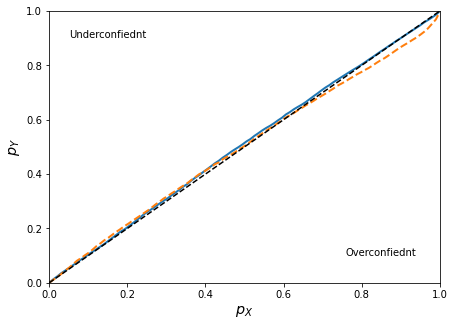

In [16]:
plt.figure(1, figsize=(7,5))
plt.plot(np.linspace(0,1,100),pYi.sum(axis=0)/10000, lw=2)
plt.plot(np.linspace(0,1,100),pYi2.sum(axis=0)/10000, lw=2, linestyle='--')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel(r"$p_X$", fontsize='x-large')
plt.ylabel(r"$p_Y$", fontsize='x-large')
plt.text(0.15, 0.9, "Underconfiednt", horizontalalignment='center')
plt.text(0.85, 0.1, "Overconfiednt", horizontalalignment='center')
plt.show()

We can see from the plot above that the new MDN alternates between underconfident and overconfident, exactly what we don't want!

If we check the accuracy of the posterior mean predictions we can see the new MDN performs worse here too.

In [17]:
err_ratio = np.abs(np.median(np.abs(means-valX), axis=0)/np.median(np.abs(means2-valX), axis=0)-1)*100
print("$m$ posterior mean predictions {0:.1f}% better from origonal MDN.".format(err_ratio[0]))
print("$c$ posterior mean predictions {0:.1f}% better from origonal MDN.".format(err_ratio[1]))

$m$ posterior mean predictions 19.7% better from origonal MDN.
$c$ posterior mean predictions 1.8% better from origonal MDN.


Finally we can save samples from the posterior prediction for our data to be compared against the other methods.

In [18]:
posterior = MDN(yscaler.transform(data.reshape(1,-1)))
samples = xscaler.inverse_transform(np.array(posterior.sample(5000)[:,0,:]))
np.save("NPE_samples", samples)